In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolops import SanitizeMol
from rdkit.Chem.MolStandardize import rdMolStandardize

import mordred
from mordred import descriptors
from sklearn.impute import SimpleImputer

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

import joblib
from mordred import Calculator, descriptors

In [3]:
# load dataset
df = pd.read_csv("./data/AqSolDB.csv")
df.head()

,Unnamed: 0,SMILES,LogS
0,0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
1,1,O=C1Nc2cccc3cccc1c23,-3.254767
2,2,Clc1ccc(C=O)cc1,-2.177078
3,3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
4,4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065


In [4]:
valid_smiles = []
valid_logs = []

for i, row in df.iterrows():
    smi = row['SMILES']
    logS = row['LogS']
    mol = Chem.MolFromSmiles(smi)
    
    if mol is not None:
        try:
            # Sanitize molecule (check valence, aromaticity, conjugation, hybridization)
            SanitizeMol(mol)
            
            # Canonicalize SMILES to have consistent representation
            clean_smi = Chem.MolToSmiles(mol, canonical=True)
            
            valid_smiles.append(clean_smi)
            valid_logs.append(logS)
        
        except Exception as e:
            # Skip molecules that fail sanitization
            continue

# Create a cleaned DataFrame
clean_df = pd.DataFrame({'SMILES': valid_smiles, 'LogS': valid_logs})

print(f"Valid molecules after sanitization: {len(clean_df)} / {len(df)}")
clean_df.head()

[21:42:19] WARNING: not removing hydrogen atom without neighbors
[21:42:19] WARNING: not removing hydrogen atom without neighbors
[21:42:19] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not removing hydrogen atom without neighbors
[21:42:20] WARNING: not r

Valid molecules after sanitization: 9980 / 9982


,SMILES,LogS
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,O=C1Nc2cccc3cccc1c23,-3.254767
2,O=Cc1ccc(Cl)cc1,-2.177078
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065


In [5]:
def standardize_molecule(mol):
    try:
        # Remove salts and fragments
        cleaner = rdMolStandardize.Cleanup(mol)
        # Normalize functional groups
        normalizer = rdMolStandardize.Normalize(cleaner)
        # Reionize to standard charge states
        reionizer = rdMolStandardize.Reionize(normalizer)
        return reionizer
    except:
        return mol  # return original if fails


In [6]:
standardized_smiles = []

for smi in df['SMILES']:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mol = standardize_molecule(mol)
        clean_smi = Chem.MolToSmiles(mol, canonical=True)
        standardized_smiles.append(clean_smi)
    else:
        standardized_smiles.append(None)

df['Standardized_SMILES'] = standardized_smiles
df = df.dropna(subset=['Standardized_SMILES']).reset_index(drop=True)

df.to_csv("./data/standardized_AqSolDB.csv", index=False)
print(f"Standardized dataset saved with {len(df)} molecules")
df.head()

[21:42:28] Initializing MetalDisconnector
[21:42:28] Running MetalDisconnector
[21:42:28] Initializing Normalizer
[21:42:28] Running Normalizer
[21:42:28] Initializing Normalizer
[21:42:28] Running Normalizer
[21:42:28] Initializing MetalDisconnector
[21:42:28] Running MetalDisconnector
[21:42:28] Initializing Normalizer
[21:42:28] Running Normalizer
[21:42:28] Initializing Normalizer
[21:42:28] Running Normalizer
[21:42:28] Initializing MetalDisconnector
[21:42:28] Running MetalDisconnector
[21:42:28] Initializing Normalizer
[21:42:28] Running Normalizer
[21:42:28] Initializing Normalizer
[21:42:28] Running Normalizer
[21:42:28] Initializing MetalDisconnector
[21:42:28] Running MetalDisconnector
[21:42:28] Initializing Normalizer
[21:42:28] Running Normalizer
[21:42:28] Initializing Normalizer
[21:42:28] Running Normalizer
[21:42:28] Initializing MetalDisconnector
[21:42:28] Running MetalDisconnector
[21:42:28] Initializing Normalizer
[21:42:28] Running Normalizer
[21:42:28] Initializ

Standardized dataset saved with 9980 molecules


,Unnamed: 0,SMILES,LogS,Standardized_SMILES
0,0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-]
1,1,O=C1Nc2cccc3cccc1c23,-3.254767,O=C1Nc2cccc3cccc1c23
2,2,Clc1ccc(C=O)cc1,-2.177078,O=Cc1ccc(Cl)cc1
3,3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...
4,4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...


In [7]:
df.head()

,Unnamed: 0,SMILES,LogS,Standardized_SMILES
0,0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-]
1,1,O=C1Nc2cccc3cccc1c23,-3.254767,O=C1Nc2cccc3cccc1c23
2,2,Clc1ccc(C=O)cc1,-2.177078,O=Cc1ccc(Cl)cc1
3,3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...
4,4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...


In [8]:
df.drop(columns="Unnamed: 0", inplace=True)
df_reordered = df[['SMILES', 'Standardized_SMILES', 'LogS']]

In [9]:
calc = mordred.Calculator(descriptors, ignore_3D=True)
mols = [rdkit.Chem.MolFromSmiles(smi) for smi in df["Standardized_SMILES"]]
mols = [mol for mol in mols if mol is not None]
mols = calc.pandas(mols=mols)

[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] Unusual charge on atom 1 number of radical electrons set to zero
[21:43:12] Unusual charge on atom 0 number of radical electrons set to zero
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] Unusual charge on atom 1 number of radical electrons set to zero
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] WARNING: not removing hydrogen atom without neighbors
[21:43:12] WARNING: not removing hydrogen atom without ne

/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc

[21:43:33] WARNING: not removing hydrogen atom without neighbors
[21:43:33] WARNING: not removing hydrogen atom without neighbors
[21:43:33] WARNING: not removing hydrogen atom without neighbors
[21:43:37] Unusual charge on atom 1 number of radical electrons set to zero
[21:43:37] Unusual charge on atom 1 number of radical electrons set to zero
[21:43:37] Unusual charge on atom 1 number of radical electrons set to zero


/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[21:43:38] Unusual charge on atom 0 number of radical electrons set to zero
[21:43:38] Unusual charge on atom 0 number of radical electrons set to zero
[21:43:38] Unusual charge on atom 0 number of radical electrons set to zero
[21:43:39] WARNING: not removing hydrogen atom without neighbors
[21:43:39] WARNING: not removing hydrogen atom without neighbors
[21:43:39] WARNING: not removing hydrogen atom without neighbors
[21:43:39] WARNING: not removing hydrogen atom without neighbors
[21:43:39] WARNING: not removing hydrogen atom without neighbors
[21:43:39] WARNING: not removing hydrogen atom without neighbors
[21:43:43] Unusual charge on atom 1 number of radical electrons set to zero
[21:43:43] Unusual charge on atom 1 number of radical electrons set to zero
[21:43:43] Unusual charge on atom 1 number of radical electrons set to zero


/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[21:43:46] WARNING: not removing hydrogen atom without neighbors
[21:43:46] WARNING: not removing hydrogen atom without neighbors
[21:43:46] WARNING: not removing hydrogen atom without neighbors
[21:43:50] WARNING: not removing hydrogen atom without neighbors
[21:43:50] WARNING: not removing hydrogen atom without neighbors
[21:43:50] WARNING: not removing hydrogen atom without neighbors


/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[21:43:54] WARNING: not removing hydrogen atom without neighbors
[21:43:54] WARNING: not removing hydrogen atom without neighbors
[21:43:54] WARNING: not removing hydrogen atom without neighbors
[21:43:56] WARNING: not removing hydrogen atom without neighbors
[21:43:56] WARNING: not removing hydrogen atom without neighbors
[21:43:56] WARNING: not removing hydrogen atom without neighbors


/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[21:43:58] WARNING: not removing hydrogen atom without neighbors
[21:43:58] WARNING: not removing hydrogen atom without neighbors
[21:43:58] WARNING: not removing hydrogen atom without neighbors
[21:43:58] WARNING: not removing hydrogen atom without neighbors
[21:43:58] WARNING: not removing hydrogen atom without neighbors
[21:43:58] WARNING: not removing hydrogen atom without neighbors
[21:44:01] WARNING: not removing hydrogen atom without neighbors
[21:44:01] WARNING: not removing hydrogen atom without neighbors
[21:44:01] WARNING: not removing hydrogen atom without neighbors
[21:44:01] WARNING: not removing hydrogen atom without neighbors
[21:44:01] WARNING: not removing hydrogen atom without neighbors
[21:44:01] WARNING: not removing hydrogen atom without neighbors
[21:44:08] WARNING: not removing hydrogen atom without neighbors
[21:44:08] WARNING: not removing hydrogen atom without neighbors
[21:44:08] WARNING: not removing hydrogen atom without neighbors
[21:45:01] WARNING: not r

In [10]:
mols = mols.apply(pd.to_numeric, errors='coerce')
mols.shape

(9980, 1613)

In [11]:
df_descriptors = pd.concat([df_reordered,mols],axis=1)
df_descriptors.shape

(9980, 1616)

In [12]:
df_descriptors.dropna(axis=1,how="all",inplace=True)
df_descriptors.shape
df_descriptors.dropna(axis=0, thresh=len(df_descriptors.columns) * 0.9, inplace=True)
df_descriptors.shape

(6674, 1552)

In [13]:
df_descriptors.dropna(axis=1,how="all",inplace=True)
meta_info = df_reordered.loc[df_descriptors.index]
df_descriptors.drop(columns=["SMILES","Standardized_SMILES","LogS"],inplace=True)
df_descriptors.isna().sum().sum()

628247

In [14]:
imp = SimpleImputer(missing_values=np.nan,strategy="mean")
imputed = imp.fit_transform(df_descriptors)
df_mols_imputed = pd.DataFrame(imputed,columns=df_descriptors.columns,index=df_descriptors.index)

In [15]:
final_df = pd.concat([meta_info, df_mols_imputed], axis=1)
final_df.shape

(6674, 1538)

In [16]:
final_df.to_csv("./data/standardized_AqSolDB_descriptors.csv")

In [17]:
# Extract features (X) and target (y)

X = final_df.iloc[:, 5:]  # columns after first 5 are Mordred descriptors
y = final_df['LogS']

In [18]:
# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

print(f"Training set: {X_train.shape[0]} molecules")
print(f"Test set: {X_test.shape[0]} molecules")

Training set: 5339 molecules
Test set: 1335 molecules


In [19]:
# Clean up data types and infinities 
X_train = X_train.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)
X_test = X_test.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# Find sparse columns 
print("Finding good columns from training data...")

# Keep columns that have data for at least 80% of the *training* set
thresh = 0.8 * len(X_train)
good_cols = X_train.dropna(axis=1, thresh=thresh).columns.tolist()

# Filter both sets to keep only these columns
X_train = X_train[good_cols]
X_test = X_test[good_cols]
print(f"Kept {len(good_cols)} non-sparse columns.")

# Imputation 
print("Calculating training means for imputation...")
training_means = X_train.mean() 
X_train = X_train.fillna(training_means)
X_test = X_test.fillna(training_means) 

# Scale the data 
print("Scaling data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)     

Finding good columns from training data...
Kept 1533 non-sparse columns.
Calculating training means for imputation...
Scaling data...


In [20]:
from sklearn.model_selection import GridSearchCV

print("Running efficient hyperparameter tuning...")

param_grid = {
    'C': [0.1, 1, 10],      
    'gamma': ['scale', 0.1], 
    'epsilon': [0.1]       
}

grid_search = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid,
    cv=3,                   
    scoring='neg_mean_absolute_error', 
    n_jobs=-1,              
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV MAE: {-grid_search.best_score_:.3f}")

best_svm = grid_search.best_estimator_
print("Optimized SVM training completed!")

Running efficient hyperparameter tuning...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale'}
Best CV MAE: 0.673
Optimized SVM training completed!


In [21]:
# Test on held-out test set
y_pred_test = best_svm.predict(X_test_scaled)


test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\nFinal test set performance:")
print(f"MAE: {test_mae:.3f}")
print(f"R²: {test_r2:.3f}")


Final test set performance:
MAE: 0.608
R²: 0.829


In [33]:
import os
save_dir = "./plots"
os.makedirs(save_dir, exist_ok=True)

  Plot saved successfully as: solubility_distribution_original.png


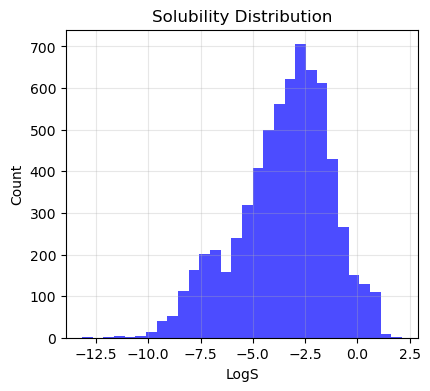

In [29]:
# Solubility distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=30, alpha=0.7, color='blue')
plt.xlabel('LogS')
plt.ylabel('Count')
plt.title('Solubility Distribution')
plt.grid(True, alpha=0.3)

filename = os.path.join(save_dir,"solubility_distribution_original.png")

plt.savefig(filename, dpi=300)
print(f"  Plot saved successfully as: {filename}")

In [23]:
svm_model = grid_search.best_estimator_
print("Using best model from GridSearch for evaluation...")

Using best model from GridSearch for evaluation...


In [24]:
print(f"\nFirst 5 test predictions:")
print(f"{'Actual':<12} {'Predicted':<12} {'Error':<10}")
print("-" * 35)
for i in range(5):
    actual = y_test.iloc[i]
    pred = y_pred_test[i]
    error = abs(actual - pred)
    print(f"{actual:<12.3f} {pred:<12.3f} {error:<10.3f}")


First 5 test predictions:
Actual       Predicted    Error     
-----------------------------------
-5.658       -3.915       1.743     
-3.130       -3.226       0.096     
-4.470       -6.195       1.725     
-1.346       -1.332       0.014     
-0.075       -0.004       0.072     


In [25]:
# Evaluation 

mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(
    "SVM's Performance on Test Set:\n"
    f"  Mean Absolute Error:      {mae_test:.3f}\n"
    f"  R²:                       {r2_test:.3f}\n"
    f"  Root Mean Squared Error:  {rmse_test:.3f}"
)


SVM's Performance on Test Set:
  Mean Absolute Error:      0.608
  R²:                       0.829
  Root Mean Squared Error:  0.903


  Plot saved successfully as ./plots/results_training_plot.png at /home/zenab-khan/CADDSeminar_2025/Task 1/Group 1/plots/results_training_plot.png


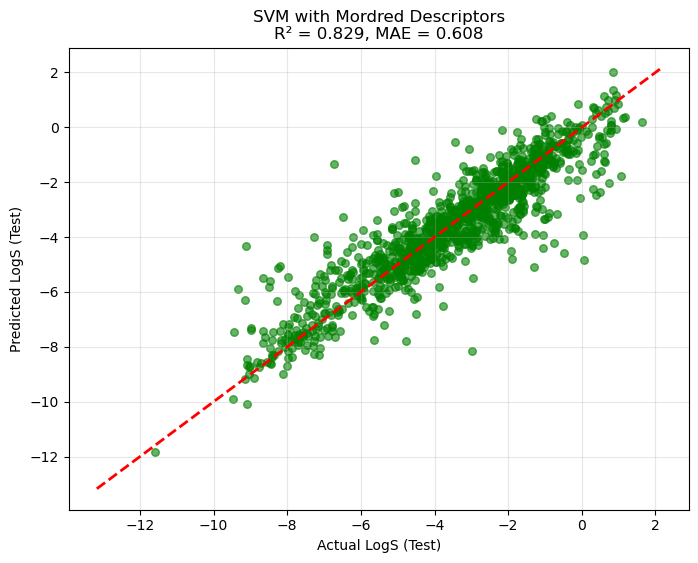

In [32]:
# Visualize

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, s=30, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual LogS (Test)')
plt.ylabel('Predicted LogS (Test)')
plt.title(f'SVM with Mordred Descriptors\nR² = {r2_test:.3f}, MAE = {mae_test:.3f}')
plt.grid(True, alpha=0.3)

filename = os.path.join(save_dir,"results_training_plot.png")

plt.savefig(filename, dpi=300)
print(f"  Plot saved successfully as {filename} at {os.path.abspath(filename)}")

plt.show()

In [28]:
# Save model
model_data = {
    'model': svm_model,                
    'scaler': scaler,                   
    'training_columns': good_cols,      
    'training_means': training_means    
}

save_dir_model = "./model" 
os.makedirs(save_dir, exist_ok=True)
filename = os.path.join(save_dir, "svm_mordred_model.pkl")

joblib.dump(model_data, filename)
print("Model and preprocessing data saved as 'svm_mordred_model.pkl'")

Model and preprocessing data saved as 'svm_mordred_model.pkl'
